<a href="https://colab.research.google.com/github/ShuaimingJing/XAI_assignment/blob/main/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 16.1 MB/s eta 0:00:00


In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import drive
import shap
import matplotlib.pyplot as plt
import torchvision.models as models
import xgboost


drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Feature Engineering

In [4]:
file_path = '/content/drive/My Drive/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df['Churn'] = df['Churn'].apply(lambda x: 0 if x == 'No' else 1)  # 0 for staying, 1 for churning
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0) # handle nah values

df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')
# df['Churn'] = df['Churn'].replace({'1': 1, '0': 0})
df['Churn'] = df['Churn'].astype(float)
df_numberical_columns = df[['SeniorCitizen','tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']]

# Dummy the non-numerical columns
non_numerical_columns = df.drop(columns=['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'customerID', 'Churn'])
df_dummies = pd.get_dummies(non_numerical_columns, drop_first=True)

df_new = df_numberical_columns.merge(df_dummies, left_index=True, right_index=True)
X = df_new.drop(columns='Churn')
y = df_new['Churn']
# Create a function to convert True/False values into 1/0
def replace_boolean_with_binary(df):
    # Create a list of columns that contain True/False values
    boolean_columns = [col for col in df.columns if df[col].dtype == bool]
    # Define the replacement dictionary
    replacement_dict = {True: 1, False: 0}
    # Loop through the boolean columns and apply the replacement
    for col in boolean_columns:
        df[col] = df[col].replace(replacement_dict)
replace_boolean_with_binary(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature_columns = X_train.columns

<ipython-input-5-acb8b80093e6>:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(replacement_dict)


# SHAP & Explanation

In [8]:
model = models.resnet34(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 146MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
model = xgboost.XGBClassifier().fit(X_train, y_train)

In [14]:
explainer = shap.TreeExplainer(model, X_train) # Use the TreeExplainer algorithm with background distribution
shap_values = explainer.shap_values(X_test) # Get shap values
shap_values_exp = explainer(X_test) # Get explainer for X_test

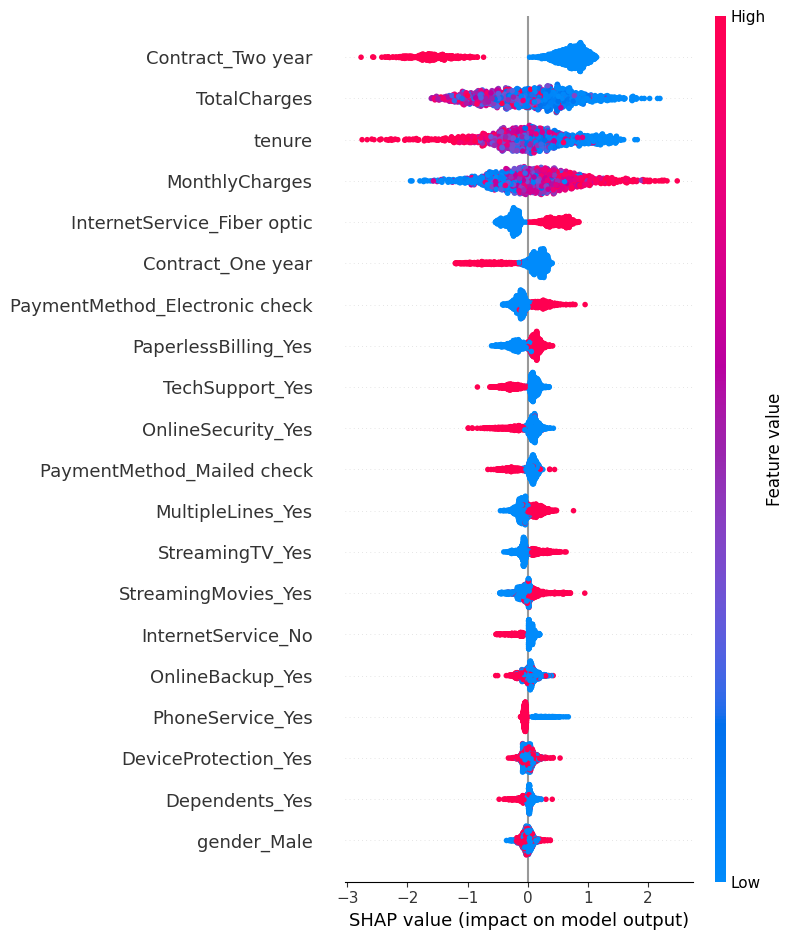

In [15]:
# Visualize SHAP with Summary Plot
shap.summary_plot(shap_values, X_test)

**Explanation**: The Summary Plot is a beeswarm plot. We can see the features listed on the left side of the plot. The bottom shows the SHAP value, which is the impact on the model output.

For classification models, especially binary classifiers, a negative SHAP value indicates that the feature is contributing to lowering the probability of the positive class (churning), or increasing the probability of the negative class.

Postive SHAP values indicate that the feature is contributing to increasing the probability of the positive class (churning).

Whether the value of the feature is low or high is shown by the color, with low feature values in blue and high feature values shown in red. This is normalized by feature.

In this plot, features like Contract_Two year, TotalCharges, tenure, and MonthlyCharges are shown as the most important for the prediction of churning. For instance, for Contract_Two year, red (high value) is associated with a negative SHAP value, meaning having a two-year contract tends to reduce the prediction churning.

Each feature has a range of SHAP values displayed as dots, showing how that feature's value affects different predictions.
For example, TotalCharges has a wide distribution of SHAP values, meaning that its impact varies significantly depending on the individual case.



# Discussion

I choose SHAP because SHAP is based on game theory and provides a solid foundation for explaining individual predictions. The difference between the
prediction and the average prediction is fairly distributed among the feature values of the instance. It also enables contrastive explanations and I can compare to the average prediction, a subset, or even to a single data point. However, it has some limitations. SHAP can be slow, especially for large models like ResNet34, as it computes feature importance for each pixel in an image. Because of this, it requires approximation to be practical. In addition, although SHAP offers precise explanations, the results can be harder to interpret for non-experts since they require understanding of SHAP values, and since SHAP uses all the features, we need access to the data.

**Potential Improvement:**  SHAP can also compute interaction effects between features. This is important for XGBoost, which can model complex non-linear interactions between variables. By using SHAP interaction values, I could better understand how pairs of features work together to impact the prediction. For instance, how tenure and TotalCharges interact to affect customer churn in a business model.
